# <center>chap3. Classification</center>
---

- **<font color='red'>binary classifiers</font>** distinguish between two classes.


- **<font color='red'>multiclass classifiers (multinomial classifiers)</font>** distinguish between more than two classes.


- **<font color='red'>multilabel classification</font>** outputs multiple binary tags.


- **<font color='red'>multioutput - multiclass classification (or multioutput classification)</font>** is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

In [1]:
# Common imports
import os
import sys
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(42)
# warnings.filterwarnings(action='ignore', message="^internal gelsd")

In [2]:
print('python version:', sys.version_info)
print('matplotlib version:', mpl.__version__)
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sklearn.__version__)

python version: sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib version: 3.1.2
numpy version: 1.18.1
pandas version: 0.25.3
scikit-learn version: 0.22.1


# 1. MNIST

Scikit-Learn provides many helper function to download popular datasets.

In [3]:
# fetch the MNIST dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

**Datasets loaded by Sklearn generally have a similar dictionary structure**, including the following:

+ A **`DESCR`** key describing the dataset.


+ A **`data`** key containing an array with one row per instance and one column per feature.


+ A **`target`** key containing an array with the labels.

In [4]:
x, y = mnist['data'], mnist['target']
x.shape, y.shape

((70000, 784), (70000,))

> There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

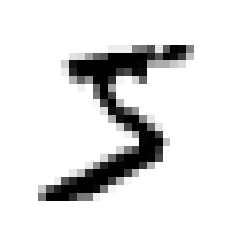

In [5]:
# Take a peek at one digit from dataset
some_digit = x[0]
some_digit_image = some_digit.reshape((28, 28))

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [6]:
y[0]  # string

'5'

In [7]:
# cat `y` to integer
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [8]:
# The MNIST dataset is actually already split into a training set
# (the first 60,000 images) and a test set (the last 10,000 images).
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

The training set is already shuffled.

**<font color='crimson'>Why the training set should be shuffled?</font>**

+ This guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some digits).


+ Some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row (连续).

# 2 Train a binary classifier

"5-detector" is an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5.

In [9]:
# True for all 5s, False for all other digits
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_train_5

array([ True, False, False, ...,  True, False, False])

**<font color='crimson'>Stochastic Gradient Descent (SGD) classifier has the advantage of being capable of handling very large datasets efficiently.</font>** This is in part because SGD deals with training instances independently, one at a time, which also makes SGD well suited for online learning.

In [10]:
from sklearn.linear_model import SGDClassifier

In [11]:
sgd_clf = SGDClassifier(max_iter=1000, tol=0.001, random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

> **The `SGDClassifier` relies on randomness during training (hence the name “stochastic”).**

In [12]:
sgd_clf.predict([some_digit])

array([ True])

# 3. Performance measures

评估 classifier 通常要比 regressor 要麻烦得多。

## 3.1 Measure accuracy using cross-validation

**<font color='green'>A good way to evaluate a model is to use cross-validation.</font>**

In [13]:
from sklearn.model_selection import cross_val_score

In [14]:
cross_val_score(estimator=sgd_clf,
                X=x_train,
                y=y_train_5,
                cv=3,
                scoring='accuracy',
                n_jobs=-1)

array([0.95035, 0.96035, 0.9604 ])

**<font color='blue'>Implement cross-validation yourself if you need more control over the cross-validation process.</font>**

In [15]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import StratifiedShuffleSplit

In [16]:
strat_k_folds = StratifiedKFold(
    n_splits=3,
    shuffle=False,
    # Only used when `shuffle` is `True`.
    # This should be left to `None` if `shuffle` is `False`.
    random_state=None)

for train_idx, test_idx in strat_k_folds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)  # important!

    x_train_fold = x_train[train_idx]
    y_train_fold = y_train[train_idx]
    x_test_fold = x_train[test_idx]
    y_test_fold = y_train[test_idx]

    clone_clf.fit(x_train_fold, y_train_fold)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print('Acc:', n_correct / len(y_pred))

Acc: 0.8787
Acc: 0.8495
Acc: 0.85815


**<font color='crimson'>Define a very dump classifier that just classifies every single image in the "not-5" class.</font>**

In [17]:
from sklearn.base import BaseEstimator

In [18]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3,
                scoring='accuracy', n_jobs=-1)

array([0.91125, 0.90855, 0.90915])

> It has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

**<font color='crimson'>This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).</font>**

## 3.2 Confusion matrix

**<font color='green'>A much better way to evaluate a classifier is to look at the confusion matrix.</font>**

In [20]:
from sklearn.model_selection import cross_val_predict

In [21]:
y_train_pred = cross_val_predict(estimator=sgd_clf,
                                 X=x_train,
                                 y=y_train_5,
                                 cv=3,
                                 n_jobs=-1)
y_train_pred

array([ True, False, False, ...,  True, False, False])

Instead of returning the evaluation scores, this returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

**<font color='crimson'>Remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch.</font>**

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

**Each row in a confusion matrix represents an actual class, while each column represents a predicted class.**

The first row of this matrix considers non-5 images (the **negative class**): 53892 of them were correctly classified as non-5s (they are called **<font color='red'>true negatives</font>**), while the remaining 687 were wrongly classified as 5s (**<font color='red'>false positives</font>**).

The second row considers the images of 5s (the **positive class**): 1891 were wrongly classified as non-5s (**<font color='red'>false negatives</font>**), while the remaining 3530 were correctly classified as 5s (**<font color='red'>true positives</font>**).

**<font color='blue'>A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right).</font>**

In [24]:
y_train_perfect_preds = y_train_5
confusion_matrix(y_train_5, y_train_perfect_preds)

array([[54579,     0],
       [    0,  5421]])

![confusion matrix](./figs/chap03-figs/confusion-matrix.png)

**<font color='red'>precision</font>**: the accuracy of the positive predictions.

$$precision=\frac{TP}{TP+FP}$$

precision is typically used along with another metric named **<font color='red'>recall</font>** (**sensitivity**, or **the true positive rate (TPR)**).

$$recall = \frac{TP}{TP+FN}$$

## 3.3 Precision and Recall

In [25]:
from sklearn.metrics import precision_score, recall_score

In [26]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [27]:
3530 / (3530 + 687)

0.8370879772350012

In [28]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [29]:
3530 / (3530 + 1891)

0.6511713705958311

It is often convenient to **combine precision and recall into a single metric** called the **<font color='red'>F1 score</font>**, **<font color='crimsion'>in particular if you need a simple way to compare two classifiers</font>**. **The F1 score is the harmonic mean of precision and recall**. Whereas(鉴于) the regular mean treats all values equally, the harmonic mean gives much more weight to low values. **As a result, the classifier will only get a high F1 score if both recall and precision are high.**

$$F_1=\frac{2}{\frac{1}{precison}+\frac{1}{recall}}=2\times \frac{precision \times recall}{precision + recall}$$

In [30]:
from sklearn.metrics import f1_score

In [31]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

**<font color='crimson'>The F1 score favors classifiers that have similar precision and recall.</font>** This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall.

Unfortunately, **you can’t have it both ways: increasing precision reduces recall, and vice versa**. This is called the **<font color='red'>precision/recall trade-off</font>**.

## 3.4 Precision/Recall trade-off

`SGDClassifier` computes a score based on a *decision function*. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

![precision-recall-trade-off](./figs/chap03-figs/precision-recall-trade-off.png)

**Lowering the threshold increases recall and reduces precision; raising the threshold increases the precision and reduces recall.**

**<font color='blue'>Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions.</font>** Calling  classifier's `decision_function()` method returns a score for each instance, and then use any threshold you want to make predictions base on those scores.

In [32]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [33]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

**<font color='crimson'>The `SGDClassifier` uses a threshold equal to 0</font>**, so the previous code returns the same result as the `predict()` method (i.e., `True`).

In [34]:
# raise the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall.

**<font color='crimson' size=3>How to decide whcih threshold to use?</font>**

+ **First**, use the **`cross_val_predict()`** to get the scores of all instances in the training set:

In [35]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3,
                             method='decision_function', n_jobs=-1)

+ **Second**, use the **`precision_recall_curve()`** to compute precision and recall for all possible thresholds:

In [36]:
from sklearn.metrics import precision_recall_curve

In [37]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5,
                                                         y_scores)


**The last precision and recall values are 1. and 0. respectively and do not have a corresponding threshold. This ensures that the graph starts on the y axis.**

In [38]:
len(precisions), len(recalls), len(thresholds)

(59967, 59967, 59966)

In [39]:
precisions[-1], recalls[-1]

(1.0, 0.0)

+ **Finally**, use Matplotlib to plot precision and recall as functions of the threshold value:

In [40]:
min(thresholds)

-106527.45300471177

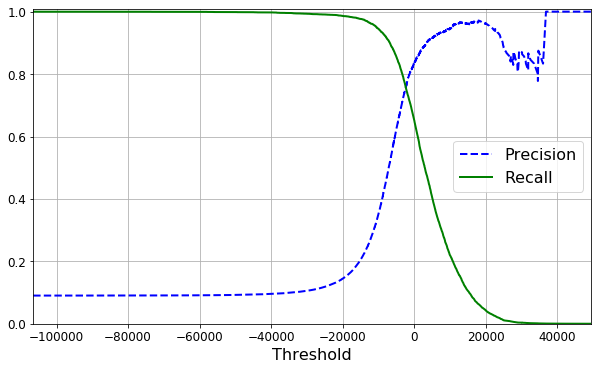

In [41]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10, 5.8))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([min(thresholds), max(thresholds), 0, 1.01])
    plt.show()    


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

You may wonder why **the precision curve is bumpier(颠簸的) than the recall curve**. The reason is that **<font color='crimson'>precision may sometimes go down when you raise the threshold (although in general it will go up)</font>**. To understand why, look back at the above figure and notice what happens when you start from the central threshold and move it just one digit to the right: precision goes from 4/5 (80%) down to 3/4 (75%). On the other hand, **<font color='crimson'>recall can only go down when the threshold is increased</font>**, which explains why its curve looks smooth.

**<font color='crimson'>Another way to select a good precision/recall trade-off is to plot precision directly against recall.</font>**

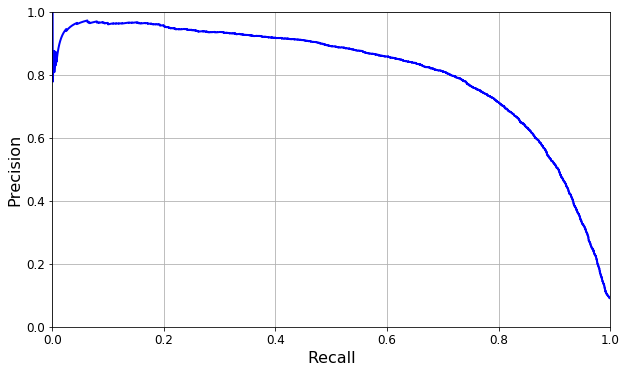

In [42]:
def plot_precision_vs_recall(precisions, recalls):
    """Plot precision against recall."""
    plt.figure(figsize=(10, 5.8))
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    plt.show()


plot_precision_vs_recall(precisions, recalls)

You can see that precision really starts to fall sharply around 80% recall. **You will probably want to select a precision/recall trade-off just before that drop** — for example, at around 60% recall. But of course, **the choice depends on your project**.

In [43]:
# aim for 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

In [44]:
# make predictions
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [45]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [46]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

**It is fairly easy to create a classifier with virtually any precision you want**: just set a high enough threshold.

**A high precision classifier is not very useful if its recall is too low.**

## 3.5 The ROC curve

The **<font color='red'>receiver operating characteristic (ROC)</font>** curve is another common tool used with binary classifiers.

**ROC curve plots the true positive rate (recall) against the false positive rate (FPR).**

<br>

$$FPR = \frac{FP}{TN+FP}=1-TNR$$

<br>

The FPR is the ratio of negative instances that are incorrectly classified as positive. The TNR is also called **<font color='red'>specificity</font>**.

Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

**<font color='crimson'>Plot ROC curve:</font>**
+ first, use the `roc_curve()` to compute the TPR and FPR for various threshold values;


+ second, plot the FPR against the TPR

In [47]:
from sklearn.metrics import roc_curve

In [48]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

len(fpr), len(tpr), len(thresholds)

(3908, 3908, 3908)

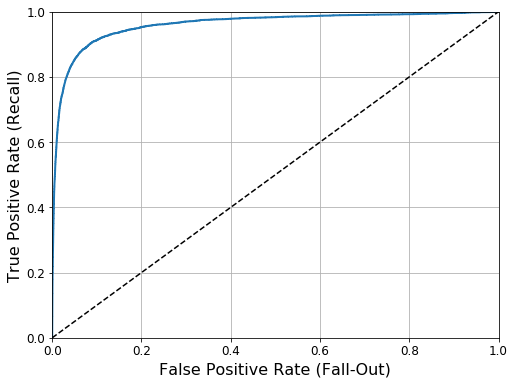

In [49]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)
    plt.show()

plot_roc_curve(fpr, tpr)

There is a **<font color='crimson'>trade-off</font>**: **the higher the recall (TPR), the more false positives (FPR) the classifier produces**.

The dotted line represents the ROC curve of a purely random classifier; **a good classifier stays as far away from that line as possible (toward the top-left corner)**.

**One way to compare classifiers is to measure the area under the curve (AUC).**

**<font color='crimson'>A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.</font>**

In [50]:
from sklearn.metrics import roc_auc_score

In [51]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

<div class="alert alert-block alert-info">
    Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. As a rule of thumb, <b>you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve.</b> For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-left corner).
</div>

Now, train a RF and compare its RO curve and ROC AU score to those of SGD.

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
y_probas_rf = cross_val_predict(rf_clf, x_train, y_train_5, cv=3,
                                method='predict_proba', n_jobs=-1)

`RandomForestClassifier` class has a **`predict_proba()`** method, instead of having a **`decision_function()`** method. **<font color='blue'>Scikit-Learn classifiers generally have one or the other, or both.</font>**

In [54]:
y_probas_rf

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

**`predict_proba()`** method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class

**`roc_curve()` function expects labels and scores, but instead of scores you can give it class probabilities**. **<font color='crimson'>Use the positive class's probability as the score.</font>**

In [55]:
# score = proba of positive class
y_scores_rf = y_probas_rf[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train_5, y_scores_rf)

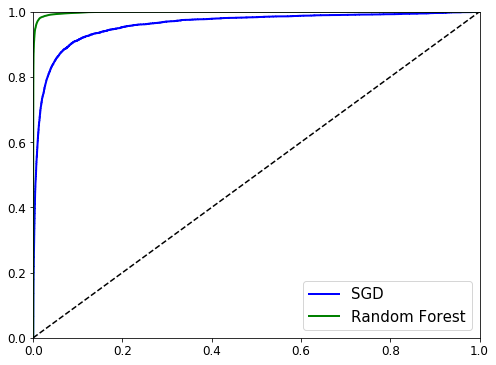

In [56]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b', lw=2, label='SGD')
plt.plot(fpr_rf, tpr_rf, 'g', lw=2, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.axis([0, 1, 0, 1])
plt.legend(fontsize=15)
plt.show()

In [57]:
roc_auc_score(y_train_5, y_scores_rf)

0.9983436731328145

In [58]:
y_train_pred_rf = cross_val_predict(rf_clf, x_train, y_train_5, cv=5, n_jobs=-1,
                                    method='predict')  # default: 'predict'

In [59]:
precision_score(y_train_5, y_train_pred_rf)

0.9910004185851821

In [60]:
recall_score(y_train_5, y_train_pred_rf)

0.8734550820881756

# 4. Multiclass classification

**<font color='red'>binary classifiers</font>** distinguish between two classes.


**<font color='red'>multiclass classifiers (multinomial classifiers)</font>** distinguish between more than two classes.

<br>

**<font color='blue'>Some algorithms (SGD clf, RF clf and NB clf) are capable of handling multiple classes natively. Others (LR clf and SVM clf) are strictly binary classifiers.</font>**

<br>

**<font color='crimson' size=3>How tot perform multiclass classification with multiple binary clf?</font>**

+ **<font color='red'>one-versus-the-rest (OvR, one-versus-all)</font>** create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then, when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score.


+ **<font color='red'>one-versus-one (OvO)</font>** train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. **If there are N classes, you need to train N × (N – 1) / 2 classifiers.** When you want to classify an image, you have to run the image through all 45 (here, N=10) classifiers and see which class wins the most duels. **<font color='blue'>The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.</font>**

<br>

**Some algorithms (such as SVM clf) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is preferred.**


**<font color='blue'>Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm.</font>**

In [61]:
from sklearn.svm import SVC

In [62]:
svc = SVC(gamma='auto',  # if 'auto', use 1/n_features
          random_state=42)
# use the first 1000 instances because svm is so slooow
svc.fit(x_train[:1000], y_train[:1000])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

> Under the hood, Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels (决斗).

In [64]:
svc.decision_function([some_digit])

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [65]:
np.argmax(svc.decision_function([some_digit]))

5

In [66]:
svc.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [67]:
svc.classes_[5]

5

**<font color='crimson' size=3>When a classifier is trained, it stores the list of target classes in its `classes_` attribute, ordered by value.</font>**

**You can use the `OneVsOneClassifier` or `OneVsRestClassifier` classes to force Sklearn to use OvO or OvR.**

In [68]:
from sklearn.multiclass import OneVsRestClassifier

In [69]:
ovr_clf = OneVsRestClassifier(
    # only 2 args
    estimator=SVC(gamma='auto', random_state=42),
    n_jobs=-1)
ovr_clf.fit(x_train[:1000], y_train[:1000])

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='auto', kernel='rbf', max_iter=-1,
                                  probability=False, random_state=42,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=-1)

In [70]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [71]:
# Estimators used for predictions.
ovr_clf.estimators_  # len -> 10

[SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
     max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
     verbose=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
     max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
     verbose=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
     max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
     verbose=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
     max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
     verbose=

In [72]:
# train a SGD classifier
# SGD clf can directly classify instances into multiple classes
sgd_clf = SGDClassifier(max_iter=1000, tol=0.001, random_state=42)
sgd_clf.fit(x_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [73]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [74]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [76]:
# evaluate the model's acc
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)

array([0.87365, 0.85835, 0.8689 ])

In [77]:
from sklearn.preprocessing import StandardScaler

In [78]:
x_train.dtype

dtype('float64')

In [79]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring='accuracy', n_jobs=-1)

array([0.8983, 0.891 , 0.9018])

# 5. Error analysis

**One way to improve model is to analyze the types of errors it makes.**

In [80]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3, n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

<Figure size 576x576 with 0 Axes>

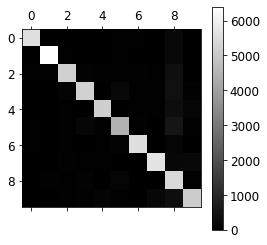

In [86]:
# often more convenient to look at an image representation of the confusion matrix
plt.figure(figsize=(8, 8))
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.colorbar()
plt.show()

The 5s look slightly darker than the other digits, which could mean

+ that there are fewer images of 5s in the dataset


+ or that the classifier does not perform as well on 5s as on other digits. 

**<font color='blue'>Divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute numbers of errors (which would make abundant classes look unfairly bad).</font>**

In [87]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

<Figure size 576x576 with 0 Axes>

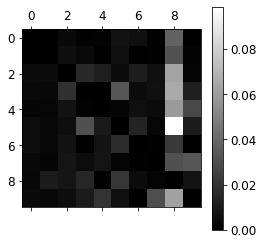

In [90]:
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.figure(figsize=(8, 8))
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.colorbar()
plt.show()

Now, you can clearly see the kinds of errors the classifier makes.

+ The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s.


+ The confusion matrix is not necessarily symmetrical.


+ 3s and 5s often get confused (in both directions).

**Analyzing the confusion matrix often gives you insights into ways to improve your classifier.**

Looking at this plot, it seems that your efforts should be spent on reducing the false 8s.

+ gather more training data for digits that look like 8s (but are not)


+ engineer new features that would help the classifier, for example, writing an algorithm to count the number of closed loops (8, 6, 5)


+ preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to some patterns (such as closed loops) stand out more.

**Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming.**

Example:

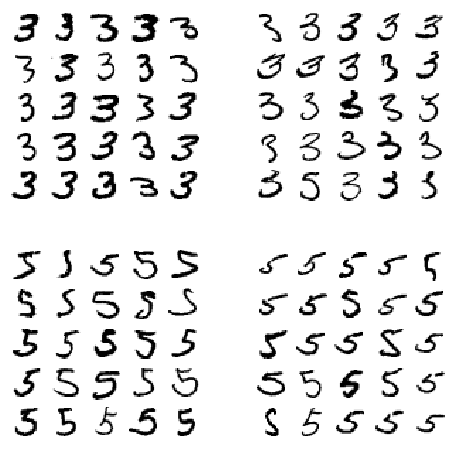

In [91]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row:(row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis("off")


# plot examples of 3s and 5s
cl_a, cl_b = 3, 5
x_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
x_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
x_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
x_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221)
plot_digits(x_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(x_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(x_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(x_bb[:25], images_per_row=5)
plt.show()

# 6. Mutlilabel classification

**<font color='red'>multilabel classification</font>** outputs multiple binary tags.

**Example**: 判断一张图片是否有张三、李四和王二麻。现在有一张只包含张三和王二麻的图片，其输出为 `[1, 0, 1]`。

In [92]:
from sklearn.neighbors import KNeighborsClassifier

In [94]:
# multilabel classification dataset
y_train_large = (y_train >=7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [95]:
knn_clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [96]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [97]:
y_multilabel[0]

array([False,  True])

In [98]:
y_train[0]

5

There are many ways to **<font color='crimson'>evaluate a multilabel classifier</font>**, and **selecting the right metric really depends on the project**. **One approach is to measure the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score**.

```python
# take a very long time
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel,
                                     cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average='macro')
```

> Simply set `average='weighted'` to give each label a weight equal to its **support** (i.e., the number of instances with that target label).

# 7. Multioutput classification

**<font color='red'>multioutput - multiclass classification (or multioutput classification)</font>** is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

**Example:**

Build a system to remove noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. The classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255).

In [102]:
# create the training and test sets
noise = np.random.randint(low=0, high=100, size=(len(x_train), 784))
x_train_noised = x_train + noise
noise = np.random.randint(0, 100, size=(len(x_test), 784))
x_test_noised = x_test + noise

y_train_noised = x_train
y_test_noised = x_test

In [103]:
def plot_digit(data):
    image = data.reshape((28, 28))
    plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis('off')

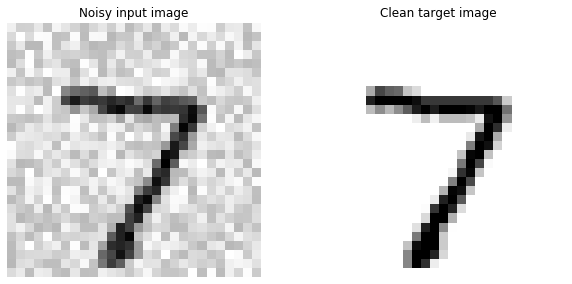

In [106]:
some_idx = 0

plt.figure(figsize=(10, 4.8))
plt.subplot(121)
plot_digit(x_test_noised[some_idx])
plt.title('Noisy input image')
plt.subplot(122)
plot_digit(y_test_noised[some_idx])
plt.title('Clean target image')
plt.show()

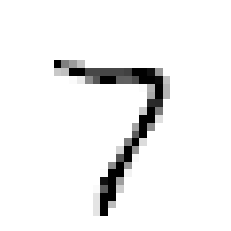

In [107]:
knn_clf.fit(x_train_noised, y_train_noised)
clean_digit = knn_clf.predict([x_test_noised[some_idx]])

plot_digit(clean_digit)
plt.show()